## 1. 패키지 다운로드 & 환경 세팅

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 728.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from transformers import SwinConfig, AutoImageProcessor, SwinForImageClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_metric

import torch
import torchvision
import numpy as np

## 2. 데이터셋 준비

In [39]:
# dataset의 features의 'image', 'labels' 를 통일시켜주는 게 편하다
# 데이터셋마다 'img', 'image', 'images' 등 다양하게 표기되어 있음

dataset = load_dataset("cats_vs_dogs")
print('기존 :', dataset)

dataset['train'] = dataset['train'].rename_column("labels", "label")
print('변경 후 :',dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

기존 : DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})
변경 후 : DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 23410
    })
})


In [41]:
# 레이블 인덱스 별 레이블 지정

labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print('인덱스 별 레이블 : ',id2label)

인덱스 별 레이블 :  {0: 'cat', 1: 'dog'}


## 3. Hugging Face 모델 세팅

*   feature_extractor : for image to patches
*   model : SwinTransformer for image classification



In [42]:
configuration = SwinConfig()
configuration.num_labels = 10

feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224",
                                                        label2id=label2id,
                                                        id2label=id2label,
                                                        ignore_mismatched_sizes = True, 
                                                       )
model = SwinForImageClassification(configuration)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



### # 데이터셋 transformation 및 preprocess 



In [13]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize((feature_extractor.size['height'], feature_extractor.size['width'])),
            CenterCrop((feature_extractor.size['height'], feature_extractor.size['width'])),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

### # 데이터셋 split 및 transform 적용


In [29]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

label : cat


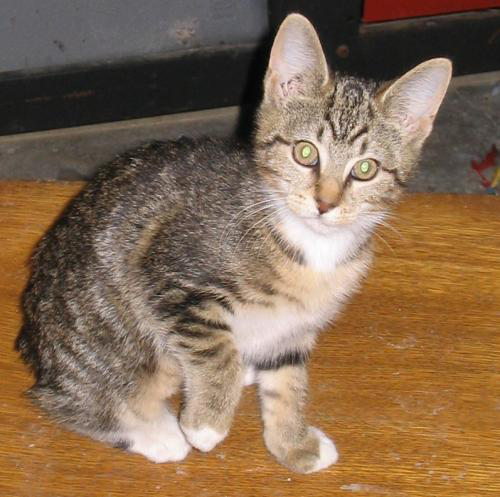

In [38]:
# 데이터셋 잘 적용되었는지 확인

example = train_ds[10]
print('label :',id2label[example['label']])
example['image']

## 4. Hugging Face `Trainer` 세팅

In [43]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

batch_size = 32

training_args = TrainingArguments(output_dir="test_trainer", 
                                  remove_unused_columns=False,
                                  evaluation_strategy = "epoch",
                                  save_strategy = "epoch",
                                  learning_rate=5e-5,
                                  per_device_train_batch_size=batch_size,
                                  gradient_accumulation_steps=4,
                                  per_device_eval_batch_size=batch_size,
                                  num_train_epochs=2,
                                  warmup_ratio=0.1,
                                  logging_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


## 5. 모델 학습

In [44]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 21069
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 328
  Number of trainable parameters = 27527044


Epoch,Training Loss,Validation Loss,Accuracy
0,0.680500,0.668503,0.570696
1,0.635200,0.642885,0.626228


***** Running Evaluation *****
  Num examples = 2341
  Batch size = 32
Saving model checkpoint to test_trainer/checkpoint-164
Configuration saved in test_trainer/checkpoint-164/config.json
Model weights saved in test_trainer/checkpoint-164/pytorch_model.bin
Image processor saved in test_trainer/checkpoint-164/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2341
  Batch size = 32
Saving model checkpoint to test_trainer/checkpoint-328
Configuration saved in test_trainer/checkpoint-328/config.json
Model weights saved in test_trainer/checkpoint-328/pytorch_model.bin
Image processor saved in test_trainer/checkpoint-328/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from test_trainer/checkpoint-328 (score: 0.626228107646305).
Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/pytorch_model.bin
Image processor save

***** train metrics *****
  epoch                    =         2.0
  total_flos               = 973885372GF
  train_loss               =      0.7056
  train_runtime            =  0:13:04.58
  train_samples_per_second =      53.708
  train_steps_per_second   =       0.418


## 6. 모델 평가

In [45]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 2341
  Batch size = 32


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.6262
  eval_loss               =     0.6429
  eval_runtime            = 0:00:23.34
  eval_samples_per_second =    100.291
  eval_steps_per_second   =       3.17


## 7. 모델 인퍼런스

- feature_extractor : pre-train된 포르세서 사용
- trained_model : 학습한 모델 정보가 있는 경로를 지정해서 학습한 모델 불러오기

In [46]:
feature_extractor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
trained_model = SwinForImageClassification(configuration).from_pretrained('/content/test_trainer/checkpoint-328/')

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--swin-tiny-patch4-window7-224/snapshots/83d40fb5b9320b349382208d9e7fe998484e99df/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

loading configuration file /content/test_trainer/checkpoint-328/config.json
Model config SwinConfig {
  "a

predicted label : dog


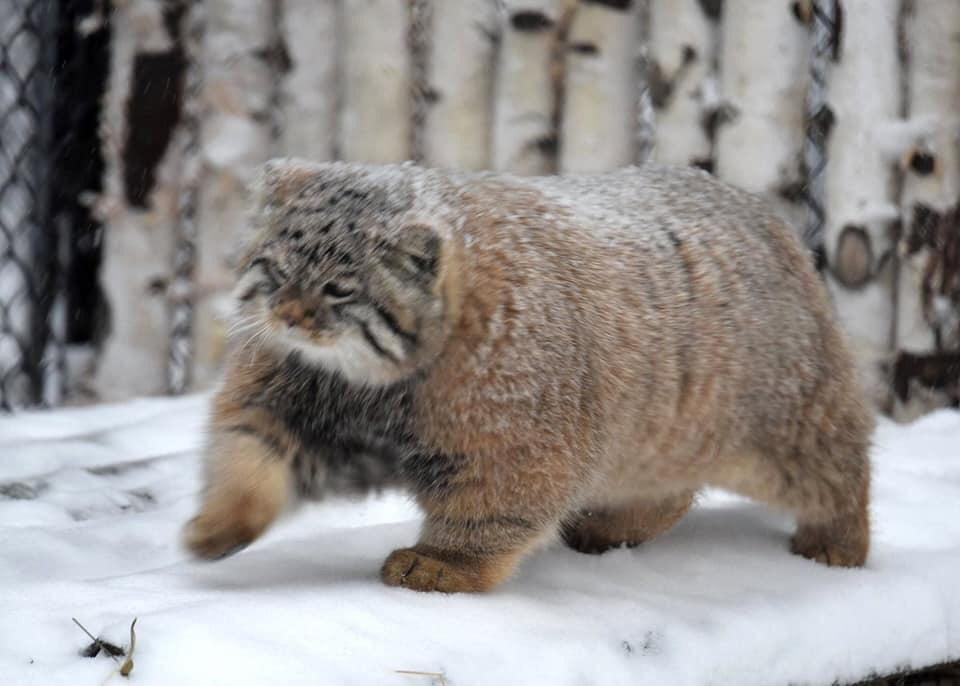

In [53]:
import requests
from io import BytesIO
from PIL import Image

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
res = requests.get(url)
image = Image.open(BytesIO(res.content))

inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    outputs = trained_model(**inputs).logits

predicted_label = outputs.argmax(-1).item()
print('predicted label :',labels[predicted_label])

image